<a href="https://colab.research.google.com/github/c-isherwood/hotel-booking-cancellation-prediction/blob/main/hotel_booking_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#tree models
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
#
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/hotel_bookings.csv'
HB = pd.read_csv(file_path)

ValueError: mount failed

# Data Cleaning

# Feature engineering

Group country by continents

In [ ]:
def fix_country_code(code):
    if pd.isna(code):
        return code
    code = str(code).strip().upper()
    if code == 'CN':
        return 'CHN'
    elif code == 'TMP':
        return 'TLS'
    return code

HB['country'] = HB['country'].apply(fix_country_code)

europe = [
    'PRT','GBR','ESP','IRL','FRA','ROU','NOR','POL','DEU','BEL','CHE','GRC','ITA',
    'NLD','DNK','SWE','FIN','AUT','LUX','SVN','ALB','UKR','LVA','SRB','LTU',
    'BLR','HRV','AND','CYP','MLT','ISL','MCO','MKD','MNE','SMR','LIE',
    'EST','CZE','HUN','SVK','BIH','BGR','GIB','JEY','GGY','IMN','FRO','RUS'
]
Non_europe= ['USA','CAN','MEX','PRI','JAM','CUB','DOM','HTI','TTO','BRB','BHS','LCA','GRD',
    'DMA','VGB','AIA','ATG','KNA','CYM','SLV','HND','NIC','BLZ','GTM','PAN',
    'CRI','GLP','ABW','BRA','ARG','CHL','URY','COL','PER','VEN','ECU','PRY','BOL','SUR','GUY'
     'CHN','JPN','KOR','IND','THA','VNM','PHL','MYS','SGP','IDN','LKA','NPL','PAK',
    'BGD','KWT','ARE','QAT','OMN','BHR','IRN','IRQ','SAU','JOR','ISR','LBN','TWN',
    'MAC','HKG','ARM','AZE','KAZ','UZB','TJK','KGZ','TKM','LAO',
    'MDV','MMR','SYR','TLS','GEO','MAR','ZAF','EGY','DZA','NGA','GHA','KEN','UGA','ZMB','ZWE','MOZ','TZA','BWA',
    'NAM','ETH','SEN','CMR','CIV','RWA','MLI','MDG','SDN','MWI','TGO','DJI','GAB',
    'AGO','BEN','LBY','MRT','CPV','COM','STP','SYC','BFA','BDI','TUN','ERI','AUS','NZL','FJI','PYF','KIR','ASM','NCL','UMI','PLW',
    'CAF','MUS','GNB','SLE','MYT','ATA','ATF'

]


def get_continent(c):
    if c is pd.NA or pd.isna(c):
        return 'Unknown'
    c = str(c).strip().upper()
    if c in europe:
        return 'Europe'
    elif c in Non_europe:
        return 'Non_Europe'
    else:
        return 'Unknown'

In [ ]:
HB['continent'] = HB['country'].apply(get_continent)
HB = HB.drop(columns=['country'])

Group monthes by seasons

In [ ]:
#change arrival month into seasons
season_map = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}
HB['season'] = HB['arrival_date_month'].map(season_map)

#Drop unrelated/null/highly correlated values

In [ ]:
HB.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'company', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status',
       'reservation_status_date', 'continent', 'season'],
      dtype='object')

Analyze errorneous data

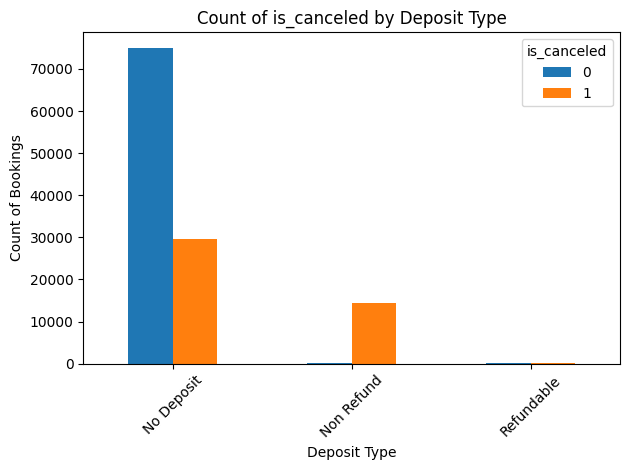

In [ ]:
count_df = HB.groupby(['deposit_type', 'is_canceled']).size().unstack(fill_value=0)

count_df.plot(kind='bar')

plt.xlabel('Deposit Type')
plt.ylabel('Count of Bookings')
plt.title('Count of is_canceled by Deposit Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

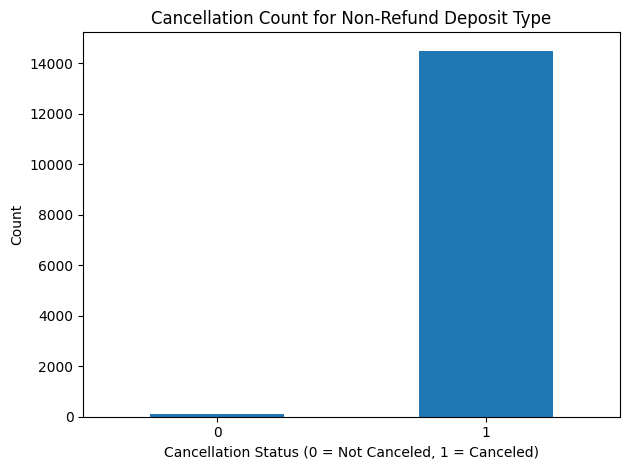

In [ ]:
df_nonrefund = HB[HB['deposit_type'] == 'Non Refund']

count_nr = df_nonrefund['is_canceled'].value_counts().sort_index()

count_nr.plot(kind='bar')

plt.xlabel('Cancellation Status (0 = Not Canceled, 1 = Canceled)')
plt.ylabel('Count')
plt.title('Cancellation Count for Non-Refund Deposit Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
non_refund_df = HB[HB['deposit_type'] == 'Non Refund']

# Cancellation rate = mean of is_canceled (because 1 = canceled, 0 = not canceled)
cancellation_rate = non_refund_df['is_canceled'].mean()

print("Cancellation rate for Non-Refundable deposit type:", round(cancellation_rate, 4))
print("As percentage:", round(cancellation_rate * 100, 2), "%")

Cancellation rate for Non-Refundable deposit type: 0.9936
As percentage: 99.36 %


Drop null value/Avoid Data Leakage/Time interval

In [ ]:
HB = HB.drop(['agent', 'company', 'reservation_status','reservation_status_date', 'arrival_date_year','arrival_date_month','deposit_type'], axis=1)

In [ ]:
#aggregate highly correlate variables into one
HB['room_match'] = (HB['reserved_room_type'] == HB['assigned_room_type']).astype(int)
HB = HB.drop(columns=['reserved_room_type', 'assigned_room_type'])

Hot-encoding

In [ ]:
#make dummies for rest of the columns
HB = pd.get_dummies(HB, drop_first=True)
#change True and false into binaries
HB.replace({True: 1, False: 0}, inplace=True)

/tmp/ipython-input-2874860376.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  HB.replace({True: 1, False: 0}, inplace=True)


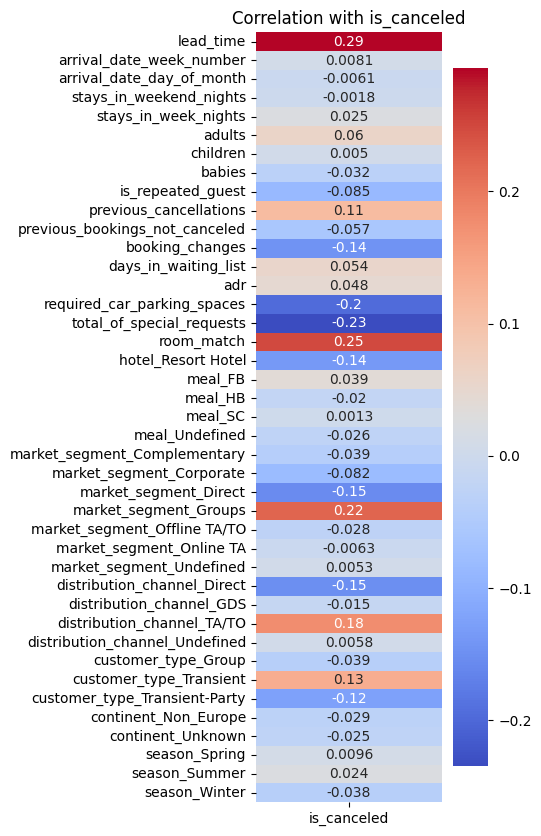

In [ ]:
corr_with_y = HB.corr()['is_canceled'].drop('is_canceled')
plt.figure(figsize=(3, 10))
sns.heatmap(corr_with_y.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation with is_canceled")
plt.show()

Examine correlation

In [ ]:
#check correlations and remove highly related columns
corr=HB.corr()
high_corr_pairs = corr.stack().reset_index()
high_corr_pairs = high_corr_pairs[(high_corr_pairs[0] > 0.8) & (high_corr_pairs['level_0'] != high_corr_pairs['level_1'])]
print(high_corr_pairs)

                          level_0                      level_1        0
1079        market_segment_Direct  distribution_channel_Direct  0.89146
1283  distribution_channel_Direct        market_segment_Direct  0.89146


In [ ]:
HB.drop(columns=['distribution_channel_Direct'], inplace=True)

Remove outliers

In [ ]:
#remove Nah on the dataset
HB['children'] = HB['children'].fillna(0)

In [ ]:
#remove extreme values
HB = HB[HB['adr'] > 0]
HB = HB[HB['adr'] < 1000]

In [ ]:
#aggregate columns
HB['total_nights'] = HB['stays_in_weekend_nights'] + HB['stays_in_week_nights']

# Balanced subset

In [ ]:
#create a balanced dataset
# 1. Split into two groups
canceled = HB[HB['is_canceled'] == 1]
not_canceled = HB[HB['is_canceled'] == 0]

# 2. Sample 20,000 from each group
canceled_10k = canceled.sample(n=20000, random_state=42)
not_canceled_10k = not_canceled.sample(n=20000, random_state=42)

# 3. Combine them
subset_balanced = pd.concat([canceled_10k, not_canceled_10k], axis=0)

# 4. Shuffle rows
subset_balanced = subset_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

subset_balanced

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,distribution_channel_Undefined,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,continent_Non_Europe,continent_Unknown,season_Spring,season_Summer,season_Winter,total_nights
0,0,98,24,10,1,2,2,0.0,0,0,...,0,0,0,1,0,0,0,1,0,3
1,1,293,32,6,0,2,2,0.0,0,0,...,0,0,0,0,0,0,0,1,0,2
2,0,184,13,26,2,3,2,0.0,0,0,...,0,0,1,0,1,0,1,0,0,5
3,1,72,16,16,0,1,2,0.0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,79,39,25,2,3,2,0.0,0,0,...,0,0,1,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1,379,30,21,0,2,2,0.0,0,0,...,0,0,1,0,0,0,0,1,0,2
39996,1,226,52,21,0,1,2,0.0,0,0,...,0,0,1,0,0,0,0,0,1,1
39997,0,124,30,17,2,2,3,0.0,0,0,...,0,0,1,0,0,0,0,1,0,4
39998,1,80,31,1,4,6,2,2.0,0,0,...,0,0,1,0,0,0,0,1,0,10


# Baseline of predictions

In [ ]:
y = HB["is_canceled"]

baseline_accuracy = y.value_counts(normalize=True).max()

print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.6252203459111463


# Train Test Split

In [ ]:
X = subset_balanced.drop(columns=['is_canceled'])
y = subset_balanced['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Data visualization

In [ ]:
def plot_box(HB):
    num_feats = HB.select_dtypes(include=['float64', 'int64']).columns

    num_plots = len(num_feats)
    num_feats_plots = 3
    num_rows_plots = (num_plots // num_feats_plots) + (num_plots % num_feats_plots > 0)

    fig, axes = plt.subplots(num_rows_plots, num_feats_plots, figsize=(15, num_rows_plots * 5))
    axes = axes.flatten()

    for i, col in enumerate(num_feats):
        sns.boxplot(HB[col], ax=axes[i])
        axes[i].set_title(f'boxplot of {col}')

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_box(HB)

KeyboardInterrupt: 

In [ ]:
important_numerical_features = HB[['is_canceled', 'lead_time',
   'previous_cancellations',
   'booking_changes','adr', 'required_car_parking_spaces',
    'total_of_special_requests']]

In [ ]:
numerical_features=HB.select_dtypes('number')
numerical_features.hist(bins=20, figsize=(15, 20), edgecolor='black')
plt.suptitle("Bar Charts of Numeric Features and Cancellations", fontsize=16)
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()

In [ ]:
important_numerical_features.hist(bins=20, figsize=(15, 20), edgecolor='black')
plt.suptitle("Bar Charts of Numeric Features and Cancellations", fontsize=16)
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()

In [ ]:
if set(["lead_time","is_canceled"]).issubset(HB.columns):
    bins = [0, 7, 30, 90, 180, 365, HB["lead_time"].max() if pd.notna(HB["lead_time"].max()) else 366]
    labels = ["0-7","8-30","31-90","91-180","181-365",">365"]
    HB["lead_time_bin"] = pd.cut(HB["lead_time"], bins=bins, labels=labels, include_lowest=True, right=True)
    q4 = HB.groupby("lead_time_bin")["is_canceled"].mean()
    print("Cancellation Rate by Lead Time")
    print((q4*100).round(2).astype(str) + "%")

    plt.figure()
    plt.bar(q4.index.astype(str), q4.values, color="#b9dfffff")
    plt.title("Cancellation Rate by Lead Time")
    plt.xlabel("Lead Time (days)")
    plt.ylabel("Cancellation Rate (%)")
    plt.show()

In [ ]:
sns.boxplot(x='is_canceled', y='lead_time', data=HB, color="#b9dfffff")
#plt.title("Lead Time vs Cancellation")

In [ ]:
#Adjust for outliers in lead time
HB = HB[HB['lead_time'] <= 594]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(y=HB['total_nights'], palette='crest')
plt.title('Distribution of Total Nights (with Outliers)')
plt.ylabel('Total Nights')
plt.tight_layout()
plt.show()

In [ ]:
#Adjust for outliers in total nights
HB = HB[HB['total_nights'] > 0]
HB = HB[HB['total_nights'] < 50]

In [ ]:
req_cancel_rate = HB.groupby('total_of_special_requests')['is_canceled'].mean().reset_index()
req_cancel_rate['is_canceled'] = req_cancel_rate['is_canceled'] * 100 # Convert to percentage

print("Cancellation rate by Number of Special Requests:")
print(req_cancel_rate)

# Determine the number of unique special request counts for the palette
n_requests = len(req_cancel_rate['total_of_special_requests'].unique())
# Generate a list of colors from the light blue palette
colors = sns.light_palette("skyblue", n_colors=n_requests)

plt.figure(figsize=(10, 6))
sns.barplot(x='total_of_special_requests', y='is_canceled', hue='total_of_special_requests', data=req_cancel_rate, palette=colors, legend=False)
plt.title('Cancellation Rate by Number of Special Requests')
plt.xlabel('Number of Special Requests')
plt.ylabel('Cancellation Rate (%)')
plt.tight_layout()
plt.show()

In [ ]:
#Adjust for outliers in Booking Changes
HB = HB[HB['booking_changes'] > 0]
HB = HB[HB['booking_changes'] <= 10]

In [ ]:
import numpy as np
from scipy.stats import linregress

booking_changes_cancellation = HB.groupby('booking_changes')['is_canceled'].mean().reset_index()
booking_changes_cancellation['is_canceled'] = booking_changes_cancellation['is_canceled'] * 100 # Convert to percentage

print("Cancellation rate by Number of Booking Changes:")
print(booking_changes_cancellation)

# Calculate the linear regression for the trend line
slope, intercept, r_value, p_value, std_err = linregress(booking_changes_cancellation['booking_changes'], booking_changes_cancellation['is_canceled'])

plt.figure(figsize=(10, 6))
sns.lineplot(x='booking_changes', y='is_canceled', data=booking_changes_cancellation, marker='o', color='skyblue', label='Cancellation Rate')

# Plot the trend line
x_trend = np.array([booking_changes_cancellation['booking_changes'].min(), booking_changes_cancellation['booking_changes'].max()])
y_trend = slope * x_trend + intercept
plt.plot(x_trend, y_trend, color='red', linestyle='--', label='Linear Trend')

plt.title('Cancellation Rate by Number of Booking Changes with Trend Line')
plt.xlabel('Number of Booking Changes')
plt.ylabel('Cancellation Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
previous_cancellations_rate = HB.groupby('previous_cancellations')['is_canceled'].mean().reset_index()
previous_cancellations_rate['is_canceled'] = previous_cancellations_rate['is_canceled'] * 100 # Convert to percentage

print("Cancellation rate by Previous Cancellations:")
print(previous_cancellations_rate)

plt.figure(figsize=(10, 6))
sns.lineplot(x='previous_cancellations', y='is_canceled', data=previous_cancellations_rate, marker='o', color='skyblue')
plt.title('Cancellation Rate by Number of Previous Cancellations')
plt.xlabel('Number of Previous Cancellations')
plt.ylabel('Cancellation Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Numerical variable correlation map

In [ ]:
# Select only numerical columns
num_df = HB.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr = num_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.3)
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

# Forward Selection

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

def forward_selection(data, target, significance_level=0.05):
    initial_features = []
    remaining_features = list(data.columns)
    selected_features = []

    while len(remaining_features) > 0:
        best_pval = 1
        best_feature = None

        for feature in remaining_features:
            try:
                model = sm.Logit(target, sm.add_constant(data[initial_features + [feature]])).fit(disp=0)
                pval = model.pvalues[feature]

                if pval < best_pval:
                    best_pval = pval
                    best_feature = feature
            except np.linalg.LinAlgError:

                print(f"skip {feature}（singular matrix）")
                continue

        if best_feature is not None and best_pval < significance_level:
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
            selected_features.append(best_feature)
            print(f"Selected: {best_feature}  |  p={best_pval:.4f}")
        else:
            break

    return selected_features
X = X_train.copy()
y = y_train

forward_features = forward_selection(X, y)
print("Final variables:", forward_features)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

# forward_features subset
X_train_sel = X_train[forward_features]
X_test_sel  = X_test[forward_features]

# Train a linear regression model
lin = LinearRegression()
lin.fit(X_train_sel, y_train)

# Predictions
y_train_prob = lin.predict(X_train_sel)
y_test_prob  = lin.predict(X_test_sel)

# Convert to class labels
y_train_pred = (y_train_prob >= 0.5).astype(int)
y_test_pred  = (y_test_prob >= 0.5).astype(int)

# Full-sample MSE & Accuracy
print("\n=== Full-sample Performance ===")
print("Train MSE:", mean_squared_error(y_train, y_train_prob))
print("Test  MSE:", mean_squared_error(y_test, y_test_prob))
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test  Accuracy:", accuracy_score(y_test,  y_test_pred))

# 5-fold CV (only show average)
kf = KFold(n_splits=5, shuffle=True, random_state=0)

train_mse_list = []
val_mse_list   = []
train_acc_list = []
val_acc_list   = []

for train_idx, val_idx in kf.split(X_train_sel):
    X_tr, X_val = X_train_sel.iloc[train_idx], X_train_sel.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LinearRegression()
    model.fit(X_tr, y_tr)

    # Predict prob
    y_tr_prob  = model.predict(X_tr)
    y_val_prob = model.predict(X_val)

    # MSE
    mse_tr  = mean_squared_error(y_tr, y_tr_prob)
    mse_val = mean_squared_error(y_val, y_val_prob)

    # Accuracy
    y_tr_pred  = (y_tr_prob >= 0.5).astype(int)
    y_val_pred = (y_val_prob >= 0.5).astype(int)

    acc_tr = accuracy_score(y_tr, y_tr_pred)
    acc_val = accuracy_score(y_val, y_val_pred)

    train_mse_list.append(mse_tr)
    val_mse_list.append(mse_val)
    train_acc_list.append(acc_tr)
    val_acc_list.append(acc_val)

print("\n=== 5-Fold CV Average Results ===")
print("Average Train MSE:", np.mean(train_mse_list))
print("Average Val   MSE:", np.mean(val_mse_list))
print("Average Train Accuracy:", np.mean(train_acc_list))
print("Average Val   Accuracy:", np.mean(val_acc_list))


# Backward Selection

In [ ]:
import numpy as np
import statsmodels.api as sm

def backward_elimination(data, target, significance_level=0.05):
    features = list(data.columns)

    # Drop constant columns first
    constant_cols = [col for col in features if data[col].nunique() <= 1]
    if constant_cols:
        print("Dropped constant columns:", constant_cols)
        for c in constant_cols:
            features.remove(c)

    while len(features) > 0:
        try:
            model = sm.Logit(target, sm.add_constant(data[features])).fit(disp=0)
        except np.linalg.LinAlgError:
            # If still singular, drop one feature and try again
            drop_feature = features[-1]
            print(f"Dropped {drop_feature} because of singular matrix")
            features.remove(drop_feature)
            if not features:
                break
            continue

        pvals = model.pvalues[1:]   # skip constant
        worst_pval = pvals.max()
        worst_feature = pvals.idxmax()

        if worst_pval > significance_level:
            print(f"Removed: {worst_feature} | p={worst_pval:.4f}")
            features.remove(worst_feature)
        else:
            break

    return features

X = X_train.copy()
y = y_train

backward_features = backward_elimination(X, y)
print("Final features:", backward_features)

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped total_nights because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped season_Winter because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped season_Summer because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped season_Spring because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped continent_Unknown because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped continent_Non_Europe because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped customer_type_Transient-Party because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped customer_type_Transient because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped customer_type_Group because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped distribution_channel_Undefined because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped distribution_channel_TA/TO because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped distribution_channel_GDS because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped market_segment_Undefined because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped market_segment_Online TA because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped market_segment_Offline TA/TO because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped market_segment_Groups because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped market_segment_Direct because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped market_segment_Corporate because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped market_segment_Complementary because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped meal_Undefined because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped meal_SC because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped meal_HB because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped meal_FB because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped hotel_Resort Hotel because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped room_match because of singular matrix
Dropped total_of_special_requests because of singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Dropped required_car_parking_spaces because of singular matrix
Removed: days_in_waiting_list | p=0.9351
Removed: stays_in_week_nights | p=0.7387
Removed: arrival_date_day_of_month | p=0.4617
Removed: children | p=0.3857
Final features: ['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'adults', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr']


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

# Subset with selected features
X_train_sel = X_train[backward_features]
X_test_sel  = X_test[backward_features]

lin = LinearRegression()
lin.fit(X_train_sel, y_train)

# Continuous predictions (treated as probabilities)
y_train_prob = lin.predict(X_train_sel)
y_test_prob  = lin.predict(X_test_sel)

# MSE
train_mse = mean_squared_error(y_train, y_train_prob)
test_mse  = mean_squared_error(y_test, y_test_prob)

# Accuracy (threshold 0.5)
y_train_pred = (y_train_prob >= 0.5).astype(int)
y_test_pred  = (y_test_prob  >= 0.5).astype(int)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

print("\n=== Linear Regression with backward-selected features ===")
print("Train MSE:", train_mse)
print("Test  MSE:", test_mse)
print("Train Accuracy:", train_acc)
print("Test  Accuracy:", test_acc)


=== Linear Regression with backward-selected features ===
Train MSE: 0.21800841370696208
Test  MSE: 0.22017560971700473
Train Accuracy: 0.64975
Test  Accuracy: 0.63525


# Lasso

Best lambda (λ*): 0.00013664483492953244
Hold-out Train MSE: 0.17490323660026397
Hold-out Test  MSE: 0.1781370099186369


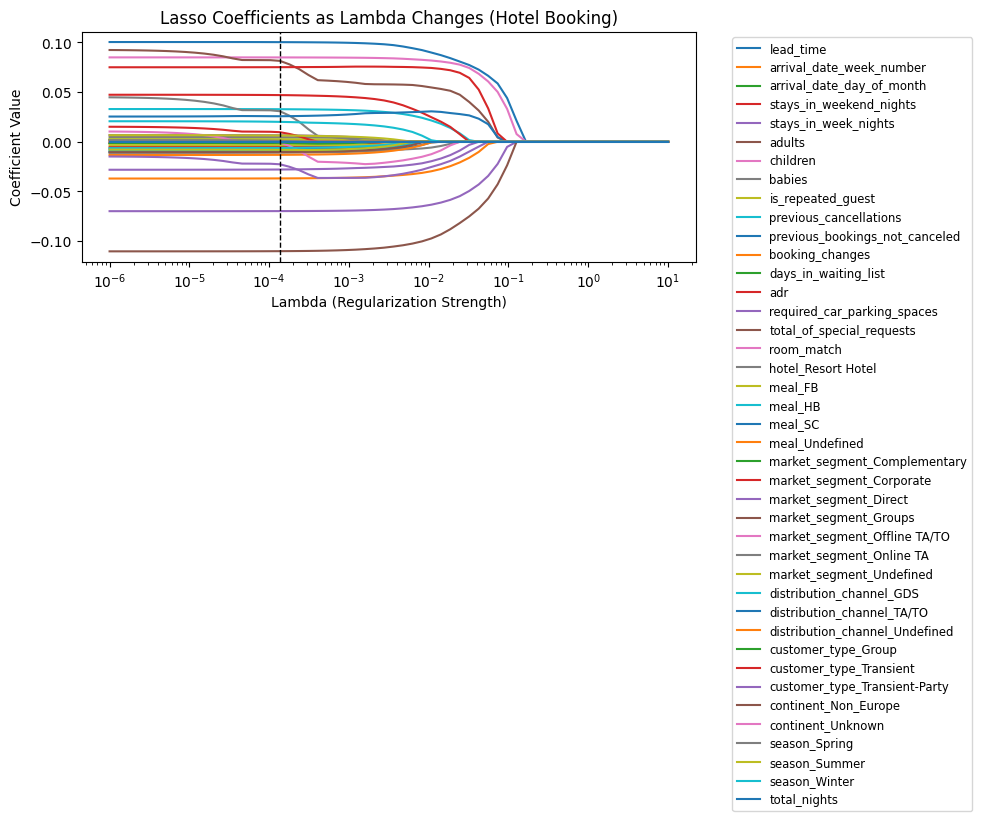

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Tune Lambda
num_lambdas = 60
lambdas = np.logspace(1, -6, num_lambdas)

# initialize storage
y_train_hat = np.zeros((y_train.shape[0], num_lambdas))
y_test_hat = np.zeros((y_test.shape[0], num_lambdas))
coefficients = np.zeros((X_train.shape[1], num_lambdas))

# fit lasso models
model = Lasso(
    alpha=lambdas[0],
    max_iter=5000,
    fit_intercept=True,
    warm_start=True,
    selection='cyclic',
    tol=1e-4
)

for i, alpha in enumerate(lambdas):
    model.alpha = alpha
    model.fit(X_train_scaled, y_train)

    y_train_hat[:, i] = model.predict(X_train_scaled)
    y_test_hat[:,  i] = model.predict(X_test_scaled)
    coefficients[:, i] = model.coef_

# Compute MSE for train and test
mse_train = np.zeros(num_lambdas)
mse_test = np.zeros(num_lambdas)

for i in range(num_lambdas):
    mse_train[i] = mean_squared_error(y_train, y_train_hat[:, i])
    mse_test[i] = mean_squared_error(y_test, y_test_hat[:, i])

# Identify best λ (minimum test MSE)
tuned_mse = np.min(mse_test)
minidx = np.argmin(mse_test)

# Hold-out MSEs at the best lambda
mse_train_best = mse_train[minidx]
mse_test_best = mse_test[minidx]

print("Best lambda (λ*):", lambdas[minidx])
print("Hold-out Train MSE:", mse_train_best)
print("Hold-out Test  MSE:", mse_test_best)



# 4. Plot coefficient shrinkage
feature_names = X.columns
plt.figure(figsize=(10,6))
for i in range(len(feature_names)):
    plt.plot(lambdas, coefficients[i, :], label=feature_names[i])

plt.axvline(lambdas[minidx], color='k', linestyle='--', linewidth=1)
plt.xscale('log')
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Coefficients as Lambda Changes (Hotel Booking)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Best lambda
print("Best lambda (λ*):", lambdas[minidx])

# Hold-out MSEs
mse_train_best = mse_train[minidx]
mse_test_best = mse_test[minidx]

print("Hold-out Train MSE:", mse_train_best)
print("Hold-out Test  MSE:", mse_test_best)

# Use best λ predictions, threshold at 0.5
y_pred_prob  = y_test_hat[:, minidx]
y_pred_class = (y_pred_prob >= 0.5).astype(int)
print("\nTest accuracy (Lasso, threshold 0.5):", accuracy_score(y_test, y_pred_class))
#print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_class))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_class))

Best lambda (λ*): 0.00013664483492953244
Hold-out Train MSE: 0.17490323660026397
Hold-out Test  MSE: 0.1781370099186369

Test accuracy (Lasso, threshold 0.5): 0.733125
Confusion matrix:
 [[2785 1177]
 [ 958 3080]]


# Ridge

In [ ]:
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier(alpha=1.0)
ridge_clf.fit(X_train, y_train)

y_pred = ridge_clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 0.733
Confusion Matrix:
 [[2783 1179]
 [ 957 3081]]


In [ ]:
from sklearn.linear_model import RidgeCV, RidgeClassifierCV

ridgecv = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)
ridgecv.fit(X_train, y_train)
print("Best alpha:", ridgecv.alpha_)

Best alpha: 10.0


In [ ]:
ridge_clf = RidgeClassifier(alpha=10.0)
ridge_clf.fit(X_train, y_train)
print("Train accuracy:", ridge_clf.score(X_train, y_train))
print("Test accuracy:", ridge_clf.score(X_test, y_test))

Train accuracy: 0.74440625
Test accuracy: 0.732


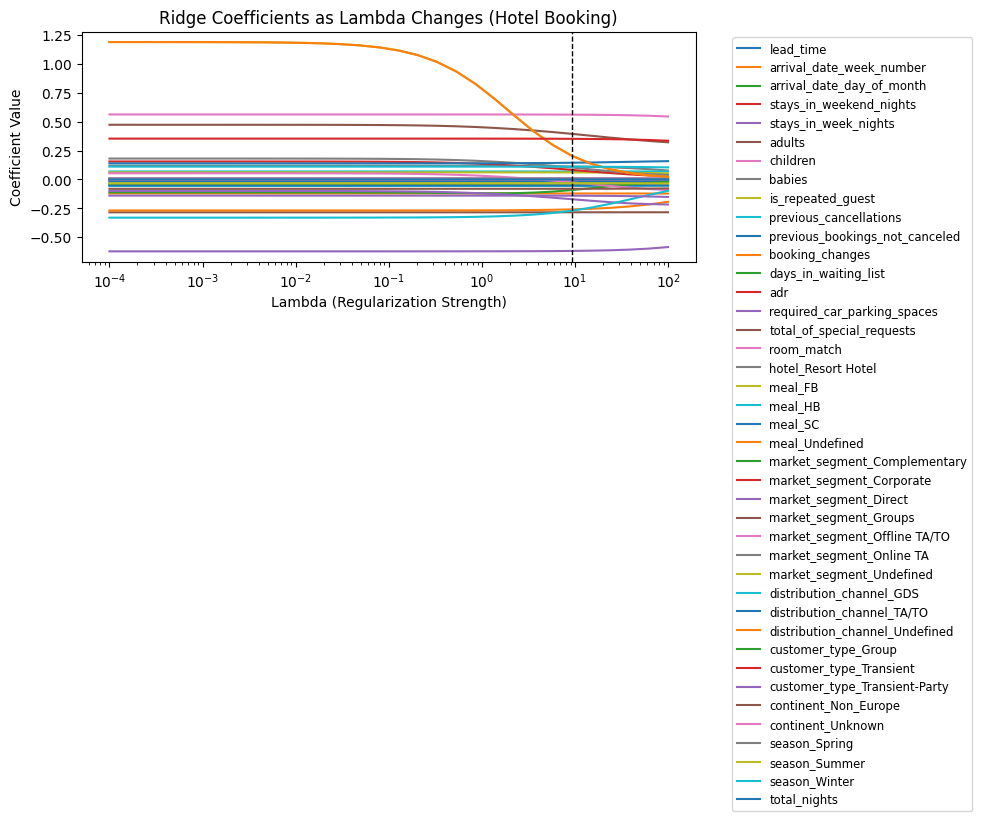

required_car_parking_spaces -0.6195427099398646
room_match 0.5608876710104218
market_segment_Groups 0.3920482533783518
customer_type_Transient 0.3512813026857241
total_of_special_requests -0.28510136453508883
distribution_channel_GDS -0.2675953316226086
meal_Undefined -0.2591552911412917
market_segment_Undefined 0.19184087195742844
distribution_channel_Undefined 0.19184087195742838
market_segment_Direct -0.17384309525975633


In [ ]:
lambdas = np.logspace(-4, 2, 30)

n_features = X_train.shape[1]
coefficients = np.zeros((n_features, len(lambdas)))

for j, alpha in enumerate(lambdas):
    ridge_clf_path = RidgeClassifier(alpha=alpha)
    ridge_clf_path.fit(X_train, y_train)
    coefficients[:, j] = ridge_clf_path.coef_.ravel()

best_alpha = 10.0
minidx = np.argmin(np.abs(lambdas - best_alpha))

#plot

feature_names = X_train.columns

plt.figure(figsize=(10, 6))
for i in range(len(feature_names)):
    plt.plot(lambdas, coefficients[i, :], label=feature_names[i])

plt.axvline(lambdas[minidx], color='k', linestyle='--', linewidth=1)
plt.xscale('log')
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Ridge Coefficients as Lambda Changes (Hotel Booking)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

coefs = ridge_clf.coef_.ravel()         # coefficients
feature_names = X_train.columns         # names

idx = np.argsort(np.abs(coefs))[::-1]
top5_idx = idx[:10]

for i in top5_idx:
    print(feature_names[i], coefs[i])

In [ ]:
coefs = ridge_clf.coef_.ravel()         # coefficients
feature_names = X_train.columns         # names

idx = np.argsort(np.abs(coefs))[::-1]
top5_idx = idx[:10]

for i in top5_idx:
    print(feature_names[i], coefs[i])

required_car_parking_spaces -0.6195427099398646
room_match 0.5608876710104218
market_segment_Groups 0.3920482533783518
customer_type_Transient 0.3512813026857241
total_of_special_requests -0.28510136453508883
distribution_channel_GDS -0.2675953316226086
meal_Undefined -0.2591552911412917
market_segment_Undefined 0.19184087195742844
distribution_channel_Undefined 0.19184087195742838
market_segment_Direct -0.17384309525975633


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_leaf': [50, 100, 200, 300, 500],
    'min_samples_split': [50, 100, 200, 300],
    'min_impurity_decrease': [0.001, 0.005, 0.01, 0.02],
    'criterion': ['gini', 'entropy'],
}

# Then, use the GridSearchCV function which combines gridsearch with
# K-fold cross validation (cv parameter)
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring = 'accuracy')
gridSearch.fit(X_train, y_train)

print('Best accuracy: ', gridSearch.best_score_)
print('Parameter values to achieve best accuracy: ', gridSearch.best_params_)
clf_dt = gridSearch.best_estimator_
y_pred_train_dt = clf_dt.predict(X_train)
y_pred_test_dt  = clf_dt.predict(X_test)
train_acc_dt = accuracy_score(y_train, y_pred_train_dt)
test_acc_dt  = accuracy_score(y_test,  y_pred_test_dt)

print("Decision Tree Train Accuracy:", train_acc_dt)
print("Decision Tree Test  Accuracy:", test_acc_dt)

KeyboardInterrupt: 

<Figure size 1000x400 with 0 Axes>

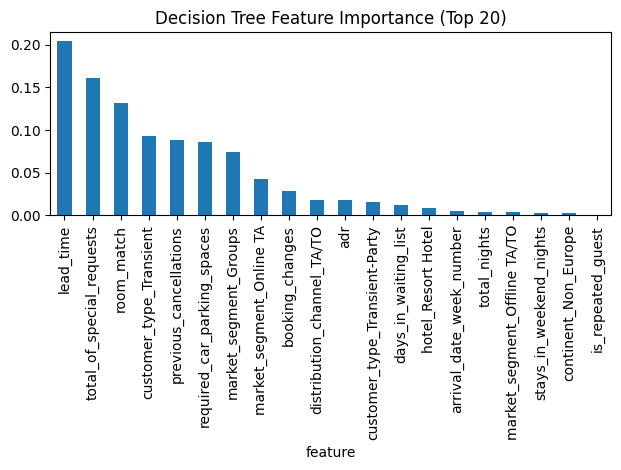

In [ ]:
importances = clf_dt.feature_importances_
imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10,4))
imp_df.head(20).plot(kind='bar', x='feature', y='importance', legend=False)
plt.title('Decision Tree Feature Importance (Top 20)')
plt.tight_layout()
plt.show()

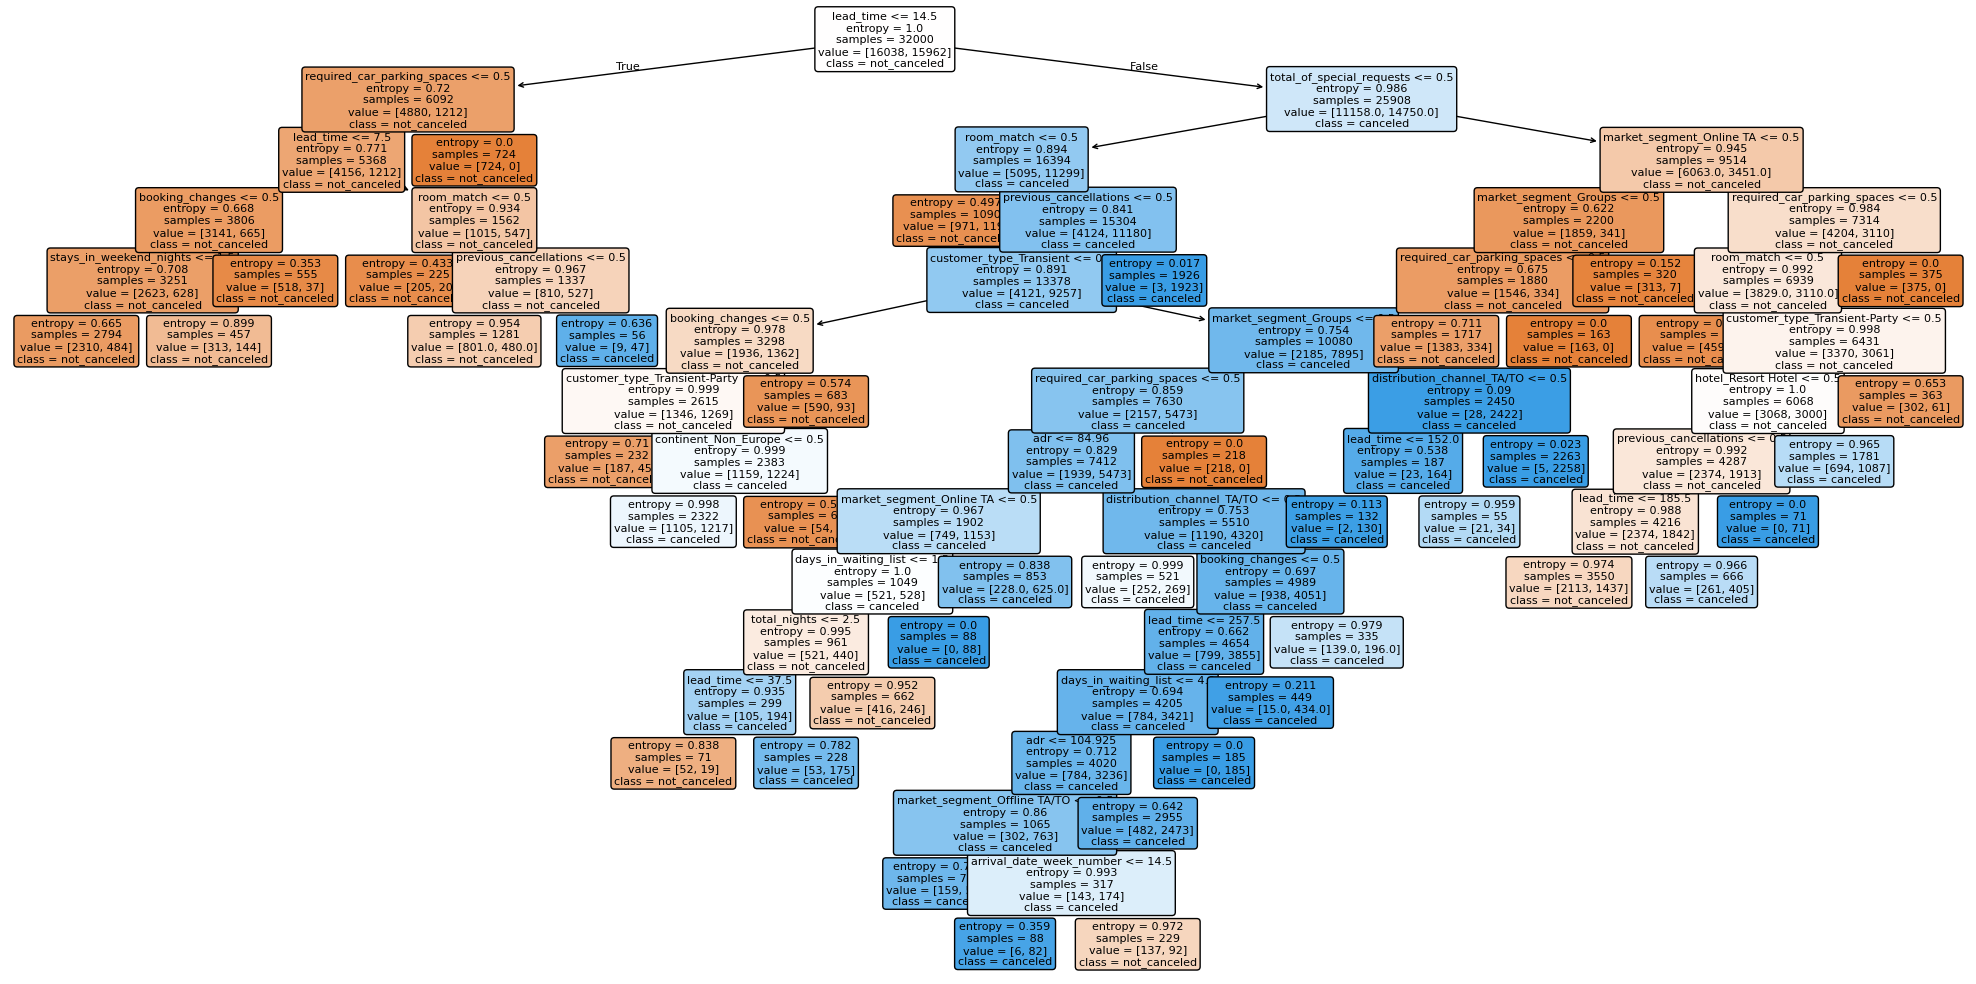

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# Basic full tree plot (can get very big)
plt.figure(figsize=(20, 10))
tree.plot_tree(
    clf_dt,
    feature_names=X_train.columns,
    class_names=['not_canceled', 'canceled'],  # change if your labels are reversed
    filled=True,
    rounded=True,
    fontsize=8
)
plt.tight_layout()
plt.show()

# Random Forest

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 12),
    'min_samples_split': randint(20, 120),
    'min_samples_leaf': randint(10, 60),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'max_samples': [0.6, 0.7, 0.8],
}

rand_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        random_state=0,
        n_jobs=-1
    ),
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    random_state=0,
    n_jobs=-1,
    verbose=1
)

rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_

train_acc = best_rf.score(X_train, y_train)
test_acc = best_rf.score(X_test, y_test)

print("Best params found by RandomizedSearchCV:")
print(rand_search.best_params_)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Overfitting gap:   {train_acc - test_acc:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params found by RandomizedSearchCV:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 264}
Training Accuracy: 0.8051
Testing Accuracy:  0.7899
Overfitting gap:   0.0152


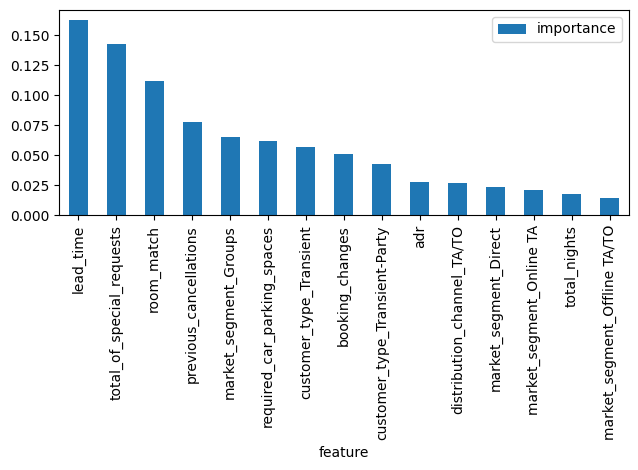

In [ ]:
importances = best_rf.feature_importances_

# create a dataframe to store the values and their labels
df2 = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# sort dataframe by descending order, showing the most important feature top
df2 = df2.sort_values('importance', ascending = False)

# plot the importance of each feature
ax = df2.head(15).plot(kind='bar', x='feature')

plt.tight_layout()
plt.show()

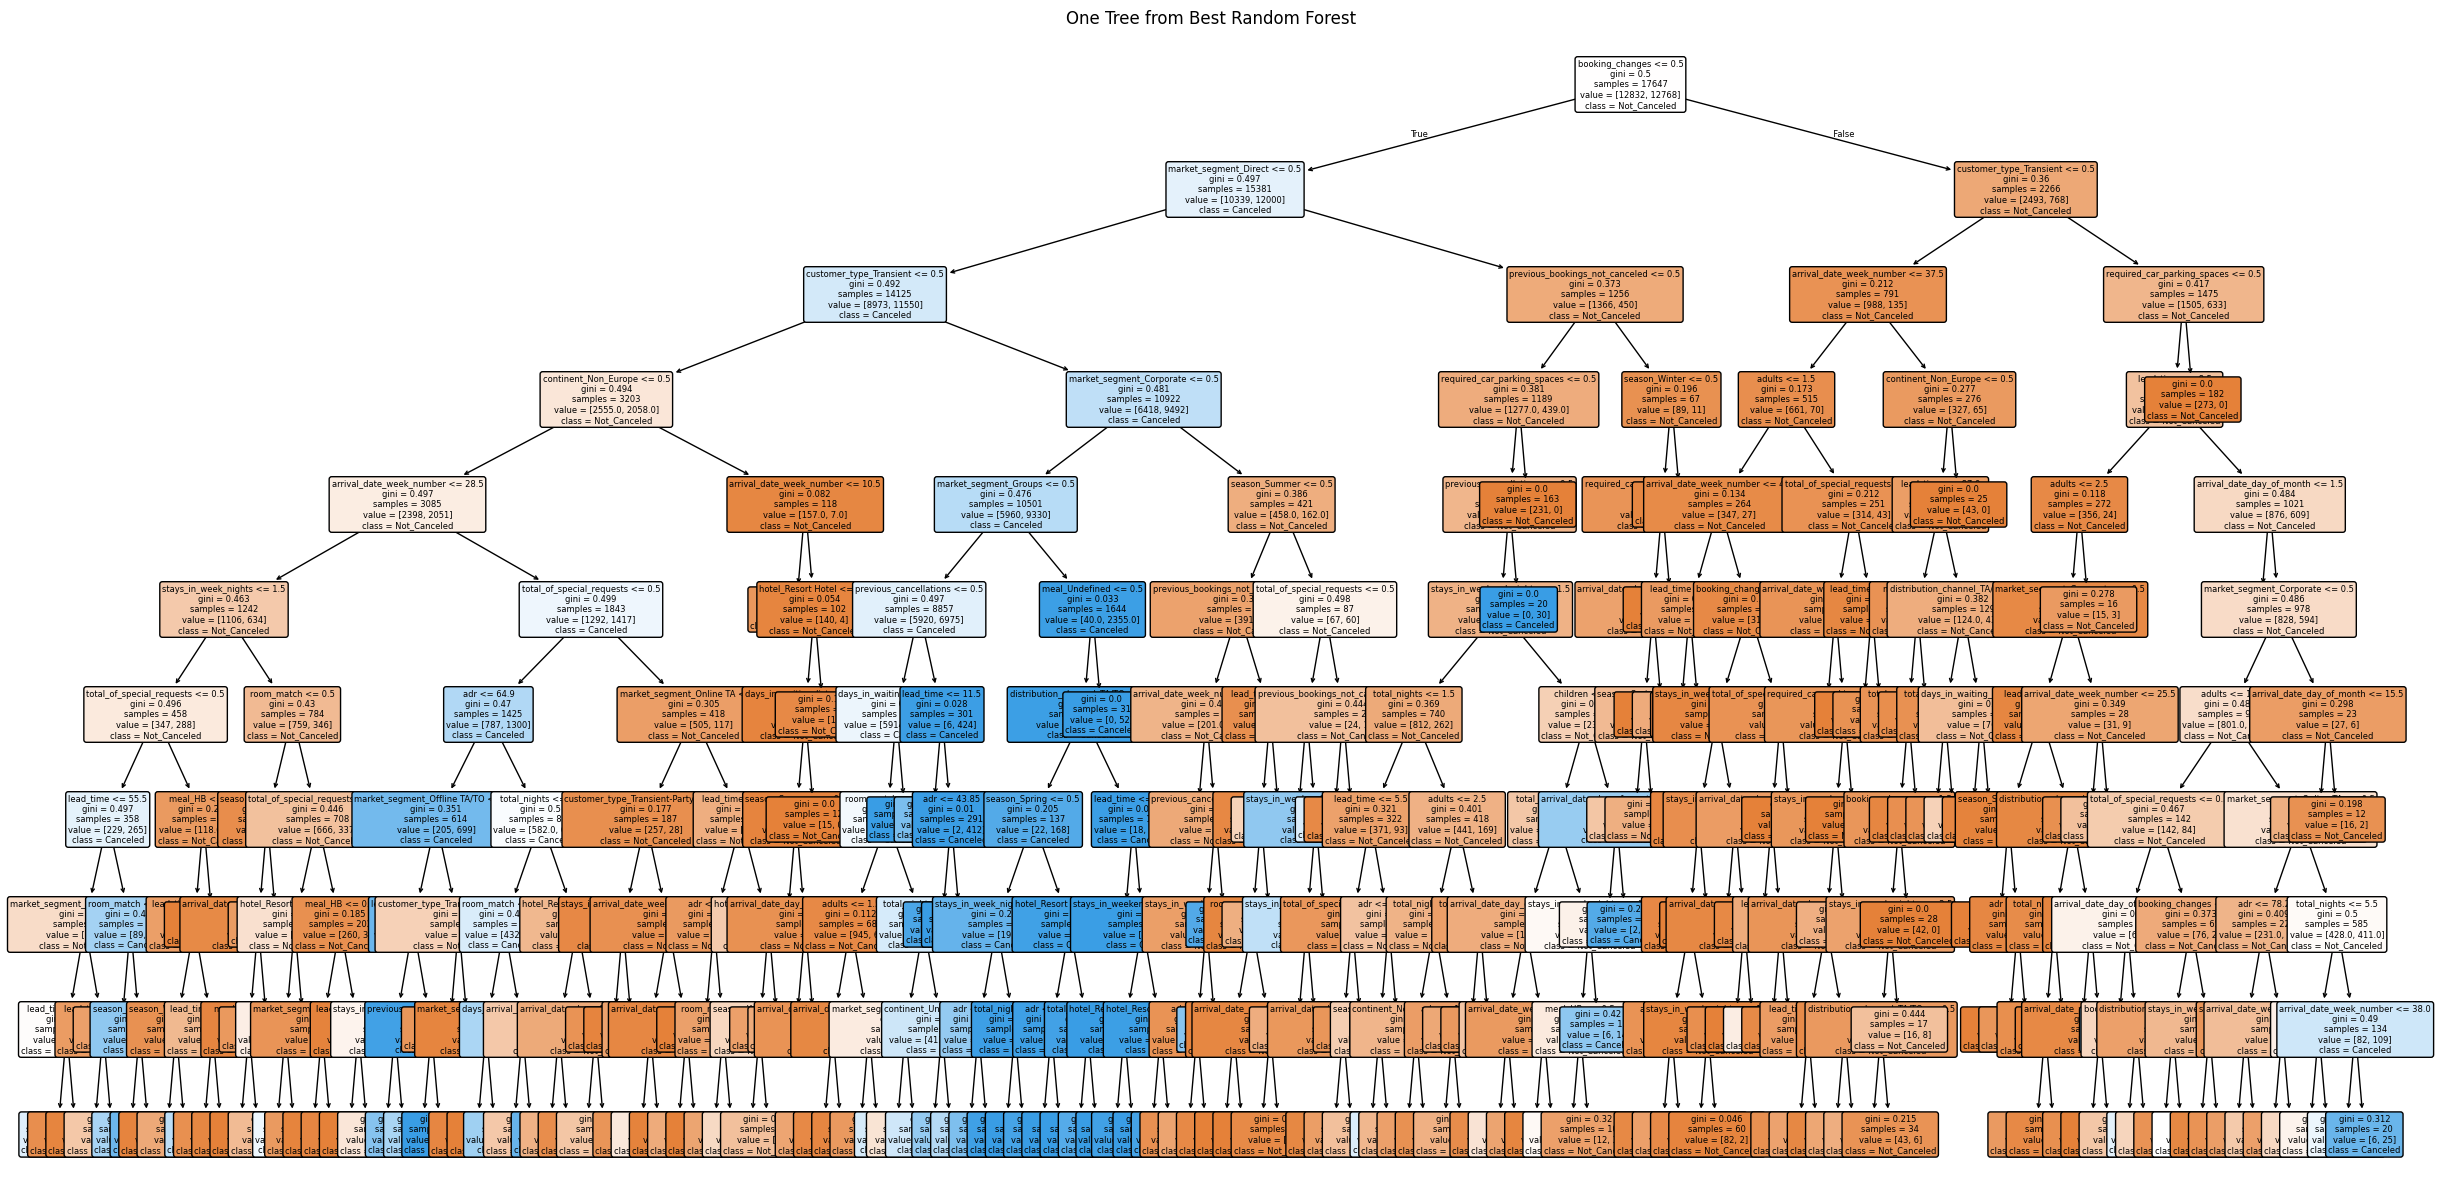

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15))
plot_tree(
    best_rf.estimators_[0],
    feature_names=X_train.columns,
    class_names=['Not_Canceled', 'Canceled'],
    filled=True,
    rounded=True,
    fontsize=6
)
plt.title("One Tree from Best Random Forest")
plt.show()

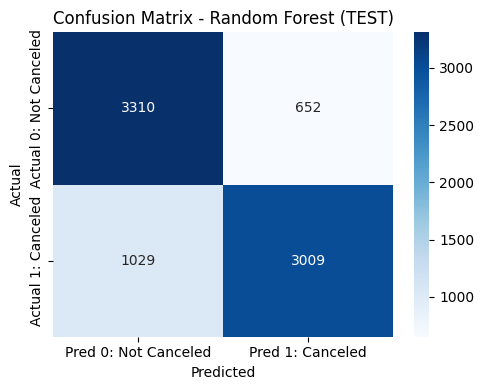

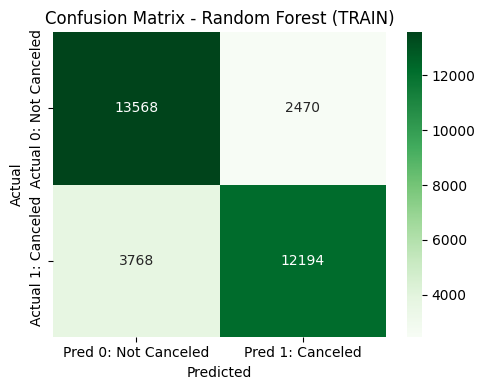


=== Test Set Performance ===
Accuracy : 0.7899
Precision: 0.8219
Recall   : 0.7452
F1 Score : 0.7817

=== Classification Report (TEST) ===
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      3962
           1       0.82      0.75      0.78      4038

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000



In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# 1. MAKE PREDICTIONS (VERY IMPORTANT)
# ==============================

y_train_pred = best_rf.predict(X_train)
y_test_pred  = best_rf.predict(X_test)   # <-- This line defines y_test_pred


# ==============================
# 2. CONFUSION MATRIX (TEST)
# ==============================

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0: Not Canceled', 'Pred 1: Canceled'],
            yticklabels=['Actual 0: Not Canceled', 'Actual 1: Canceled'])
plt.title("Confusion Matrix - Random Forest (TEST)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


# ==============================
# 3. CONFUSION MATRIX (TRAIN) — optional
# ==============================

cm_train = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred 0: Not Canceled', 'Pred 1: Canceled'],
            yticklabels=['Actual 0: Not Canceled', 'Actual 1: Canceled'])
plt.title("Confusion Matrix - Random Forest (TRAIN)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


# ==============================
# 4. METRICS (TEST)
# ==============================

test_acc      = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall    = recall_score(y_test, y_test_pred)
test_f1        = f1_score(y_test, y_test_pred)

print("\n=== Test Set Performance ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1 Score : {test_f1:.4f}")

print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_test_pred))

# Boosting Tree

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf_bt = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=300,
    learning_rate=0.1,
    algorithm="SAMME",
    random_state=42
)

clf_bt.fit(X_train, y_train)

train_acc = clf_bt.score(X_train, y_train)
test_acc  = clf_bt.score(X_test, y_test)

print("Training Accuracy:", round(train_acc, 4))
print("Testing Accuracy: ", round(test_acc, 4))
print("Overfitting Gap:  ", round(train_acc - test_acc, 4))

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Training Accuracy: 0.7472
Testing Accuracy:  0.7381
Overfitting Gap:   0.0091


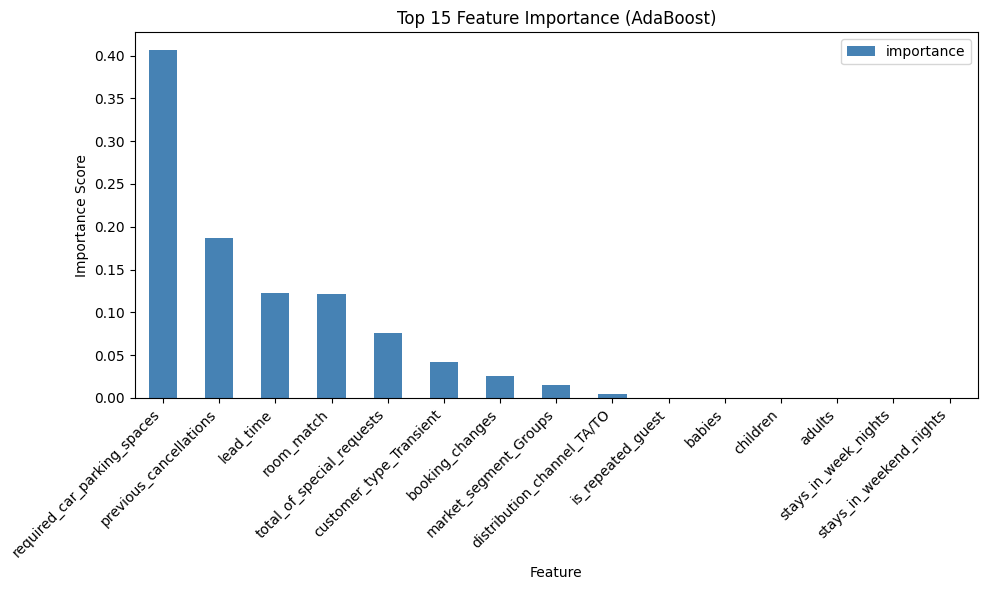

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
importances = clf_bt.feature_importances_
df2 = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})
df2 = df2.sort_values('importance', ascending=False)
ax = df2.head(15).plot(
    kind='bar',
    x='feature',
    figsize=(10, 6),
    color='steelblue'
)

plt.title("Top 15 Feature Importance (AdaBoost)")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Neuro Network

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(
    max_iter=300,
    random_state=0
)

param_grid = {
    'hidden_layer_sizes': [(20,), (50,), (50, 20)],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu', 'logistic']
}

grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}
Best CV accuracy: 0.8035626119245184


In [ ]:
best_mlp = grid.best_estimator_

# Train accuracy
y_train_pred = best_mlp.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)


# Test accuracy
y_test_pred = best_mlp.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Train accuracy:", train_acc)
print("Test accuracy :", test_acc)

Train accuracy: 0.82303125
Test accuracy : 0.803125


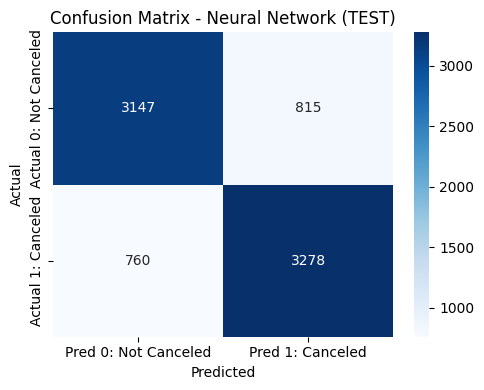

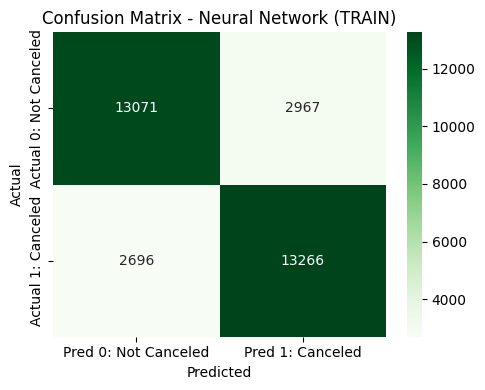


=== NN Test Set Performance ===
Accuracy : 0.8031
Precision: 0.8009
Recall   : 0.8118
F1 Score : 0.8063

=== NN Classification Report (TEST) ===
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3962
           1       0.80      0.81      0.81      4038

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000



In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# 1. PREDICTIONS
y_train_pred_nn = best_mlp.predict(X_train)
y_test_pred_nn  = best_mlp.predict(X_test)

# 2. CONFUSION MATRIX (TEST)
cm_test_nn = confusion_matrix(y_test, y_test_pred_nn)

plt.figure(figsize=(5,4))
sns.heatmap(cm_test_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0: Not Canceled', 'Pred 1: Canceled'],
            yticklabels=['Actual 0: Not Canceled', 'Actual 1: Canceled'])
plt.title("Confusion Matrix - Neural Network (TEST)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# 3. CONFUSION MATRIX (TRAIN)
cm_train_nn = confusion_matrix(y_train, y_train_pred_nn)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train_nn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred 0: Not Canceled', 'Pred 1: Canceled'],
            yticklabels=['Actual 0: Not Canceled', 'Actual 1: Canceled'])
plt.title("Confusion Matrix - Neural Network (TRAIN)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# 4. METRICS (TEST)
test_acc_nn       = accuracy_score(y_test, y_test_pred_nn)
test_precision_nn = precision_score(y_test, y_test_pred_nn)
test_recall_nn    = recall_score(y_test, y_test_pred_nn)
test_f1_nn        = f1_score(y_test, y_test_pred_nn)

print("\n=== NN Test Set Performance ===")
print(f"Accuracy : {test_acc_nn:.4f}")
print(f"Precision: {test_precision_nn:.4f}")
print(f"Recall   : {test_recall_nn:.4f}")
print(f"F1 Score : {test_f1_nn:.4f}")

print("\n=== NN Classification Report (TEST) ===")
print(classification_report(y_test, y_test_pred_nn))

<Figure size 800x400 with 0 Axes>

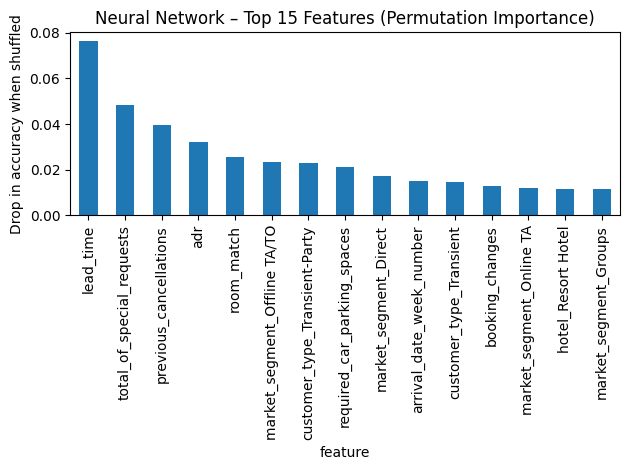

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# 1. Compute permutation importance on TEST data
result_nn = permutation_importance(
    best_mlp,           # your tuned NN
    X_test, y_test,
    n_repeats=10,
    random_state=0,
    n_jobs=-1
)

# 2. Put into DataFrame
imp_nn = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result_nn.importances_mean
}).sort_values('importance', ascending=False)

# 3. Plot top 15
plt.figure(figsize=(8,4))
imp_nn.head(15).plot(
    kind='bar',
    x='feature',
    y='importance',
    legend=False
)
plt.title("Neural Network – Top 15 Features (Permutation Importance)")
plt.ylabel("Drop in accuracy when shuffled")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
!pip install nnv

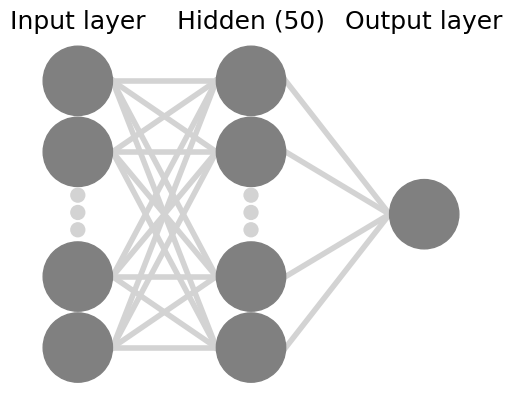

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [ ]:
from nnv import NNV
layersList = [
    {"title": "Input layer",  "units": X_train.shape[1]},
    {"title": "Hidden (50)",  "units": 50},
    {"title": "Output layer", "units": 1},
]

NNV(layersList).render(save_to_file="nn_arch.png")

# KNN

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
print("Data split and scaled successfully, with 'deposit_type' dummy variables dropped.")

Data split and scaled successfully, with 'deposit_type' dummy variables dropped.


In [ ]:
#7 neighbors has the highest accuracy (tested 1-20 neighbors)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"KNN Model Accuracy: {accuracy:.4f}")
print("\nModel Classification Results:")
print(report)

KNN Model Accuracy: 0.7816

Model Classification Results:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3962
           1       0.78      0.78      0.78      4038

    accuracy                           0.78      8000
   macro avg       0.78      0.78      0.78      8000
weighted avg       0.78      0.78      0.78      8000



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

knn_cv = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={'n_neighbors': range(1, 21)},
    cv=5,
    scoring='accuracy'


)

knn_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21)}, scoring='accuracy')

In [ ]:
print(f"Best Parameters: {knn_cv.best_params_}")
print(f"Best Score: {knn_cv.best_score_:.4f}")

Best Parameters: {'n_neighbors': 5}
Best Score: 0.7779


In [ ]:
#drop deposit_type
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"KNN Model Accuracy: {accuracy:.4f}")
print("\nModel Classification Results:")
print(report)

KNN Model Accuracy: 0.7809

Model Classification Results:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3962
           1       0.81      0.74      0.77      4038

    accuracy                           0.78      8000
   macro avg       0.78      0.78      0.78      8000
weighted avg       0.78      0.78      0.78      8000



In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions on the training set using the KNN model
y_pred_knn_train = knn.predict(X_train_scaled)

# Evaluate the KNN model on the training set
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)


In [ ]:
# Re-run KNN model training and evaluation with the updated feature set
knn = KNeighborsClassifier(n_neighbors=7) # Keeping n_neighbors=7 as it was previously identified as optimal
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"KNN Model Accuracy (without deposit_type dummies): {accuracy:.4f}")
print("\nModel Classification Results (without deposit_type dummies):")
print(report)

KNN Model Accuracy (without deposit_type dummies): 0.7816

Model Classification Results (without deposit_type dummies):
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3962
           1       0.78      0.78      0.78      4038

    accuracy                           0.78      8000
   macro avg       0.78      0.78      0.78      8000
weighted avg       0.78      0.78      0.78      8000



In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
Predicted     0     1
Actual               
0          3091   871
1           876  3162


# Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Initialize and train the Logistic Regression model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_canceled = LogisticRegression(solver='liblinear', random_state=42)
model_canceled.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_canceled_pred = model_canceled.predict(X_test_scaled)

# Evaluate the model
accuracy_canceled = accuracy_score(y_test, y_canceled_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

conf_matrix_canceled = confusion_matrix(y_test, y_canceled_pred)
class_report_canceled = classification_report(y_test, y_canceled_pred)

print(f"Test Accuracy: {accuracy_canceled}")
print(f"Train Accuracy: {train_accuracy}")

print(f"Confusion Matrix:\n{conf_matrix_canceled}")
print(f"Classification Report:\n{class_report_canceled}")

Test Accuracy: 0.745875
Train Accuracy: 0.82303125
Confusion Matrix:
[[2862 1100]
 [ 933 3105]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      3962
           1       0.74      0.77      0.75      4038

    accuracy                           0.75      8000
   macro avg       0.75      0.75      0.75      8000
weighted avg       0.75      0.75      0.75      8000



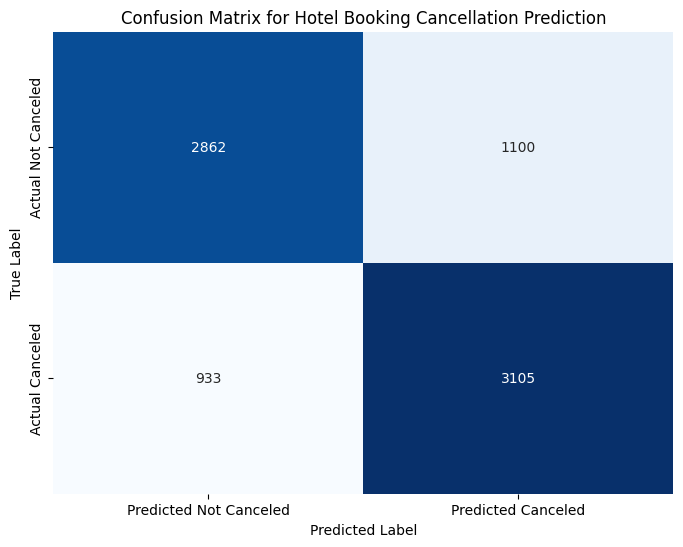

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_canceled, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Not Canceled', 'Predicted Canceled'],
            yticklabels=['Actual Not Canceled', 'Actual Canceled'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Hotel Booking Cancellation Prediction')
plt.show()